 <h4>Author: Mr. Chandramohan Reddy ANKIREDDYPALLI &nbsp;&nbsp; &nbsp; &nbsp;Email: chandramohanreddyab@gmail.com &nbsp;&nbsp; &nbsp; &nbsp; Contact: +33 766 785 789</h4>   

### Business Understanding:

**Money laundering is the illegal process of concealing the origins of money obtained illegally by passing it through a complex sequence of banking transfers or commercial transactions. The overall scheme of this process returns the "clean" money to the launderer in an obscure and indirect way. Majoring money laundering is done when large amounts of money generated by criminal activity, such as drug trafficking or terrorist funding, appear to have come from a legitimate source. Money laundering is a serious financial crime that is employed by white-collar and street-level criminals alike, and Most financial companies have anti-money-laundering (AML) policies in place to detect and prevent this activity.**

**For a financial institution, it is important to define Anti-money-laundering (AML) policies and procedures to combat money laundering by stopping criminals from engaging in transactions to disguise the origins of funds connected to illegal activity. To develop AML policies, strategies, financial institutions have to follow the trends, laws, and news-related money laundering. Every day a lot of news articles are published on money laundering, and automated news classifiers help financial analysts, policymakers to understand current scenarios by classifying money laundering articles out of many financial articles.**

### Business Problem: Classifying whether a document is related to money laundering or not

**Document/New Article is textual information that represents thoughts, often the manifestation of non-fictional, fictional, content related to a topic. In our case, The classifier has to detect the documents/articles that are related to Money laundering. To solve a problem with help of machine learning where unstructured text is involved, I follow the following approach.**

<img src="Capture.jpg">

In this notebook, we will use
1. Preprocessing: All steps
2. Text to vector:CountVector, TD-IDF, Word2Vec
3. Modelling: Classification
4. Evaluation: Accuracy, f1_score, Precision

### Table of Contents:
> **[Importing necessary libraries](#id1)**   
> **[Data Description](#id2)**    
> **[Pre processing](#id3)**    
> **[Text Vectorization + Modelling](#id4)**      
   - **[Count Vector +Logistic Regression](#id5)**     
   - **[TDIDF + Naive Bayes](#id6)**     
   - **[Word2Vec + Neural Net Classfier](#id7)**              

> **[Ending Notes](#id8)** 

### Importing necessary Libraries
<div id="id1"></div>

In [1]:
	#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to read data, transform data
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter

# for processing text
import re
import nltk
import string
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

# for vectorization, evaluation, modeling
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import gensim.downloader as gensim_api
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from gensim import corpora, models

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ChAnDu_AB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ChAnDu_AB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data Description:
<div id="id2"></div>

**Document**  : New article   
**ML_Article**: Money Laundering article or not

In [3]:
#reading data from local disk
data=pd.read_excel('Money_Laundering.xlsx')
data.head(3)

,Document,ML_Article
0,Money laundering gang sentenced over £5 millio...,Yes
1,Slovenia made progress in tackling money laund...,Yes
2,Money laundering and driving offences arrest i...,Yes


In [4]:
#checking documents distribution
data['ML_Article'].value_counts()/data.shape[0]

No     0.762376
Yes    0.237624
Name: ML_Article, dtype: float64

**Bar plot to analyse distribution of classes of documents**

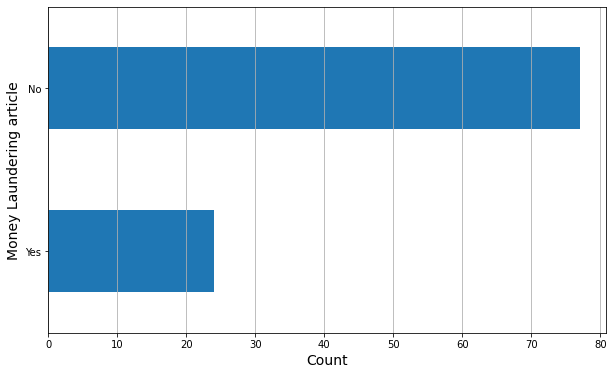

In [5]:
#plotting bar plot
fig, ax = plt.subplots()
data["ML_Article"].reset_index().groupby("ML_Article").count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax, figsize=(10,6)).grid(axis='x')
plt.xlabel('Count',size=14)
plt.ylabel('Money Laundering article',size=14)
plt.show()

<font color=brown>**Observations:**</font><br>
<font color=darkblue>1. It's a class imbalace problem where 76% of the documents are not realted to money laundering.
<br>2. So it is recommended to use other metrics instead of accuaracy, apply feature engineering to extract new features, and differenct approaches to meet business requirements  </font><br>  

### Text Pre processing
<div id="id3"></div>

In [6]:
#UDF to removed unicodes, numbers,etc
def cleaning_text(text):
    # Remove Unicode
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove Mentions
    text = re.sub(r'@\w+', '', text)
    # Lowercase the document
    text = text.lower()
    # Remove punctuations
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    # Lowercase the numbers
    text = re.sub(r'[0-9]', '', text)
    # Remove the doubled space
    text = re.sub(r'\s{2,}', ' ', text)
    return text

In [7]:
#UDF to remove stopwords, and perfomr stemming, and lemmatization
def preprocess_text(text, stemm=False, lemm=True, stopwords=None):
    #cleaning text
    text=cleaning_text(text=text)
    # Tokenization by spliting stentence at space
    proc_text = text.split()
    # removing Stopwords 
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
        proc_text = [word for word in proc_text if word not in stopwords]
    else:
        proc_text = [word for word in proc_text if word not in stopwords]                
    # Stemming (remove -ing, -ly, ...) using NLTK stemmer
    if stemm == True:
        stemmer = nltk.stem.porter.PorterStemmer()
        proc_text = [stemmer.stem(word) for word in proc_text]               
    # Lemmatisation (convert the word into root word) using NLTK lemmtizer
    if lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        proc_text = [lem.lemmatize(word) for word in proc_text]            
    # back to string from list
    text = " ".join(proc_text)
    return text

In [8]:
data["processed_document"] = data["Document"].apply(lambda x: preprocess_text (x, stemm=False, lemm=True))
data.head(5)

,Document,ML_Article,processed_document
0,Money laundering gang sentenced over £5 millio...,Yes,money laundering gang sentenced million cash s...
1,Slovenia made progress in tackling money laund...,Yes,slovenia made progress tackling money launderi...
2,Money laundering and driving offences arrest i...,Yes,money laundering driving offence arrest wimborne
3,US hands Swiss bank red card in FIFA bribe sca...,No,u hand swiss bank red card fifa bribe scandal
4,30 million Counting Machine Seized From Govern...,No,million counting machine seized government cle...


**Word Frequency Histogram**

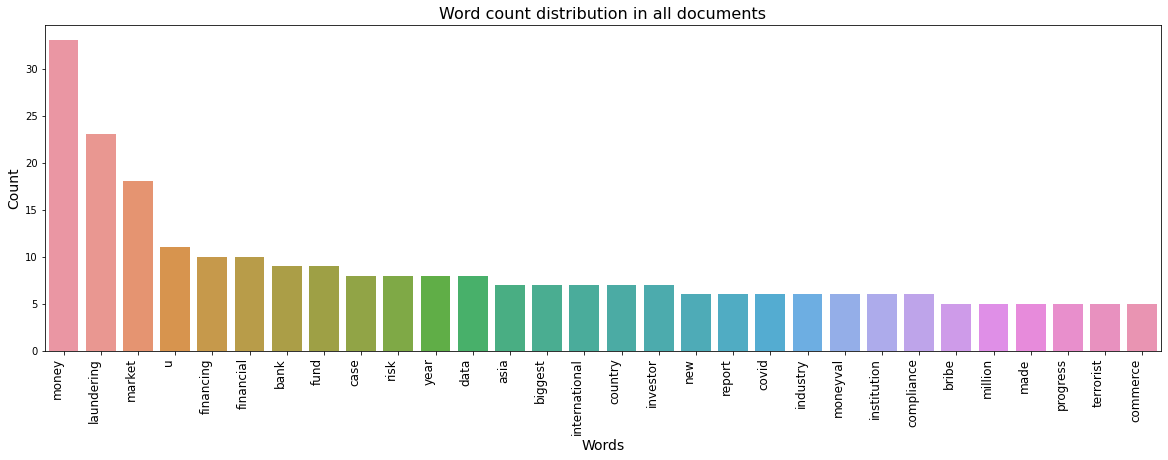

In [11]:
#extracting top 30 most repeated words
counts = dict(Counter(' '.join(data['processed_document'].to_list()).split()).most_common(30))
labels, values = zip(*counts.items())

# sort your values in descending order
ind_sort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[ind_sort]
values = np.array(values)[ind_sort]
indexes = np.arange(len(labels))

#Plotting 
plt.figure(figsize=(20,6))
ax=sns.barplot(indexes, values)
plt.title('Word count distribution in all documents',size=16)
plt.xlabel('Words', size=14)
plt.ylabel('Count', size=14)
plt.xticks(indexes , labels,size=12)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

### Text vectorization + Modelling
<div id="id4"></div>

**Data preparation for training**

In [12]:
X=data['processed_document'].copy()
y=data['ML_Article']
classes=data['ML_Article'].unique().tolist()
# encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y = np.array([inverse_dic[i] for i in y])
#splitting the data for validation purpose
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=7542)
print('Tagert varible encoding: ',dic_y_mapping)

Tagert varible encoding:  {0: 'No', 1: 'Yes'}


### Count Vector + Logistic Regression
<div id="id5"></div>

**Count Vector**

**The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.**

In [13]:
proc_corpus = data['processed_document']
count_vector = feature_extraction.text.CountVectorizer()
count_vector.fit(proc_corpus)

CountVectorizer()

**Logistic Regresssion**

In [14]:
classifier=LogisticRegression()
# pipeline
lr_model = pipeline.Pipeline([("vectorizer", count_vector), ("classifier", classifier)])
# train classifier
lr_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

**Model Evaluation**

In [15]:
#UDF to plot confusion matrix
def plot_confusion_matric(y_test, y_test_pred,y_train, y_train_pred):   
    
    #calculate confusion matric for train, and test
    cm_test = confusion_matrix(y_test, y_test_pred)
    cm_train = confusion_matrix(y_train, y_train_pred)
    
    #plot confusion matrix
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=axs[0])
    sns.heatmap(cm_test, annot=True, fmt='d',cmap=plt.cm.Blues, cbar=False, ax=axs[1])
    axs[0].set(xlabel="Predicted", ylabel="Actual", xticklabels=[0, 1], yticklabels=[0, 1], title="Confusion matrix Train")
    axs[1].set(xlabel="Predicted", ylabel="Actual", xticklabels=[0, 1], yticklabels=[0, 1], title="Confusion matrix Test")
    plt.tight_layout()
    plt.show()
    
    #print classification reports for train and test
    print('\n------------------------- Model evalution on Train data  ------------------------- \n')
    print(classification_report(y_train,y_train_pred))
    print('\n----------------------- Model evalution on validation data ----------------------- \n')
    print(classification_report(y_test,y_test_pred))
    plt.show
 
#UDF to plot ROC curve
def plot_roc_curve(y_test, y_test_prob,y_train, y_train_prob):
    fig, ax = plt.subplots(2,2, figsize=(14,14))
    
    # Plot roc curve for train
    fpr, tpr, thresholds = roc_curve(y_train, y_train_prob[:,1])
    ax[0][0].plot(fpr, tpr, lw=3,color='orange')
    ax[0][0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0][0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="ROC for Train")
    ax[0][0].legend(loc="lower right")
    ax[0][0].grid(True)

    # Plot precision-recall curve for train
    precision, recall, thresholds = precision_recall_curve(y_train, y_train_prob[:,1])
    ax[0][1].plot(recall, precision, lw=3,color='orange')
    ax[0][1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve For Train")
    ax[0][1].legend(loc="best")
    ax[0][1].grid(True)
    
    
     # Plot roc curve for test
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob[:,1])
    ax[1][0].plot(fpr, tpr, lw=3,color='orange')
    ax[1][0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[1][0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="ROC for Test ")
    ax[1][0].legend(loc="lower right")
    ax[1][0].grid(True)

    # Plot precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob[:,1])
    ax[1][1].plot(recall, precision, lw=3,color='orange')
    ax[1][1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve for Test")
    ax[1][1].legend(loc="best")
    ax[1][1].grid(True)
    
    plt.show()

In [16]:
#predicting target variable on train,and test data
y_train_pred=lr_model.predict(X_train)
y_train_prob=lr_model.predict_proba(X_train)
y_test_pred=lr_model.predict(X_test)
y_test_prob=lr_model.predict_proba(X_test)

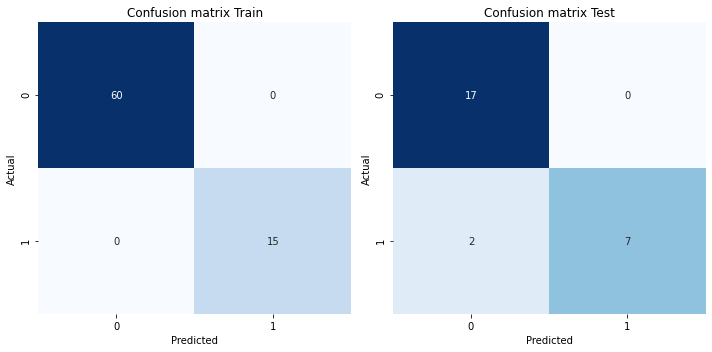


------------------------- Model evalution on Train data  ------------------------- 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        15

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75


----------------------- Model evalution on validation data ----------------------- 

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.78      0.88         9

    accuracy                           0.92        26
   macro avg       0.95      0.89      0.91        26
weighted avg       0.93      0.92      0.92        26



In [17]:
#plot confusion matrix for predicted values
plot_confusion_matric(y_test, y_test_pred,y_train, y_train_pred)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


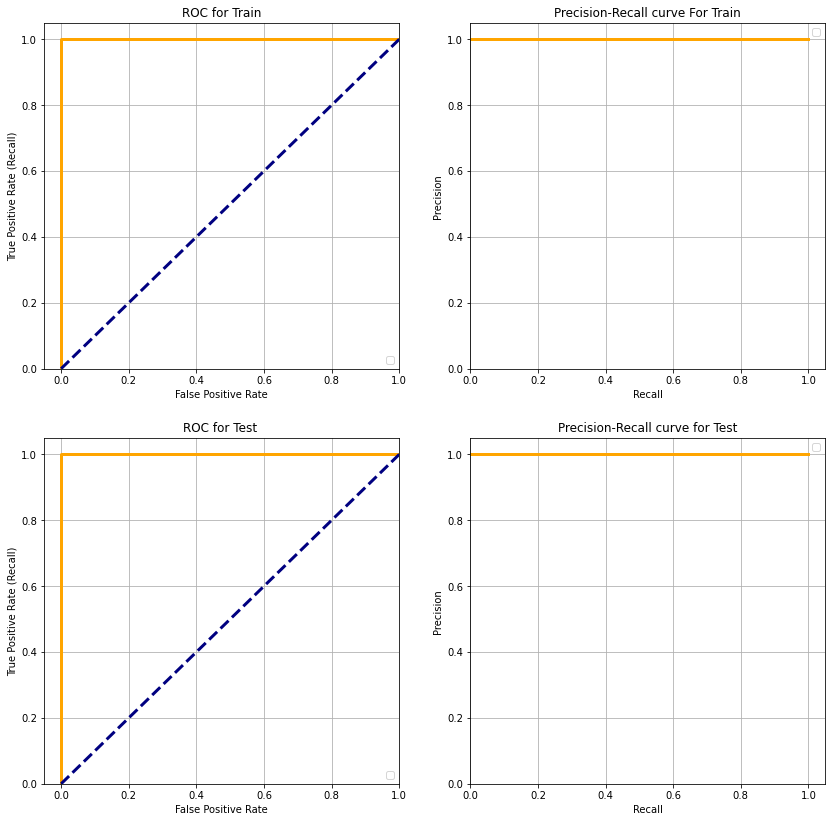

In [18]:
#plot ROC, PR curve for classifier on train and test
plot_roc_curve(y_train, y_train_prob,y_test, y_test_prob)

### TDIDF + Logistic Regression
<div id="id6"></div>

**TDIDF**

**TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics:** 
- **The term frequency of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.**  
- **The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.**

**So, if the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1**

In [19]:
tdidf_vector = feature_extraction.text.TfidfVectorizer()
tdidf_vector.fit(proc_corpus)

TfidfVectorizer()

**NaiveBayes**

In [20]:
classifier = naive_bayes.MultinomialNB()
#pipeline
nb_model = pipeline.Pipeline([("vectorizer", tdidf_vector), ("classifier", classifier)])
#train classifier
nb_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

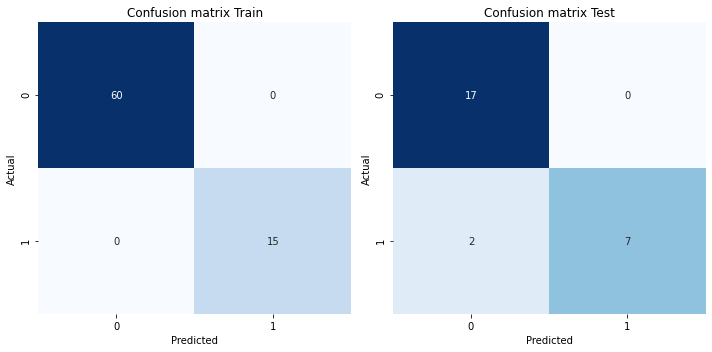


------------------------- Model evalution on Train data  ------------------------- 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        15

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75


----------------------- Model evalution on validation data ----------------------- 

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.78      0.88         9

    accuracy                           0.92        26
   macro avg       0.95      0.89      0.91        26
weighted avg       0.93      0.92      0.92        26



In [21]:
#predicting target variable on train,and test data
y_train_pred=lr_model.predict(X_train)
y_train_prob=lr_model.predict_proba(X_train)
y_test_pred=lr_model.predict(X_test)
y_test_prob=lr_model.predict_proba(X_test)

#plot confusion matrix for predicted values
plot_confusion_matric(y_test, y_test_pred,y_train, y_train_pred)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


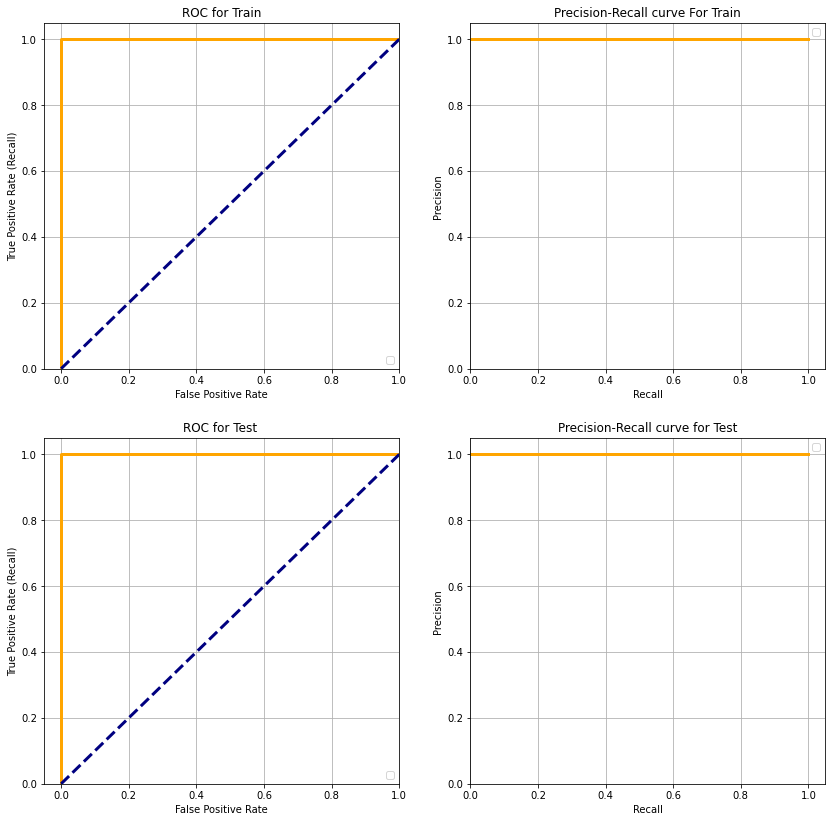

In [22]:
#plot ROC, PR curve for classifier on train and test
plot_roc_curve(y_train, y_train_prob,y_test, y_test_prob)

### Word2Vec + Neural Network classfier
<div id="id7"></div>

**Word2Vec**

Word2vec is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep neural networks can understand.

- Two ways: Using pre-trained model or training own Word2Vec model, but I am going to train my own word2vec model but if you want to use pre-trained you can use the following line to download it from gensim repo
- Pretrained word2vec: `word2vec = gensim_api.load("word2vec-google-news-300")`   

**To train neural network classifier using word2Vec, embedding matrix has to be calculated as follows**

- Transform the corpus into padded sequences of word ids to get a feature matrix.
- Create an embedding matrix so that the vector of the word with id N is located at the Nth row.
- Build a neural network with an embedding layer that weighs every word in the sequences with the corresponding vector.

In [23]:
# UDF to build a corpus from documents
def build_corpus(documents):
    "Creates a list of lists containing words from each sentence"
    corpus=[]
    for string in documents:
        words = string.split()
        unigram = [" ".join(words[i:i+1]) for i in range(0, len(words), 1)]
        corpus.append(unigram)
    return corpus

# UDF to generate Padded sequence of words
def get_feature_sequence(documents,maxlen=15):
    
    # tokenize text
    tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(documents)
    dic_vocabulary = tokenizer.word_index

    # create sequence
    sequence= tokenizer.texts_to_sequences(documents)
    
    # padding sequence
    feature_sequence = kprocessing.sequence.pad_sequences(sequence, maxlen=maxlen, padding="post", truncating="post")

    return dic_vocabulary,feature_sequence

#UDF to generate Emebeeding from feature sequence
def calculate_embeddings(w2v_model,dic_vocab,embedding_vector_size):
    ## start the matrix (length of vocabulary x vector size) with all 0s
    embeddings = np.zeros((len(dic_vocab)+1, embedding_vector_size))
    for word,idx in dic_vocab.items():
        ## update the row with vector
        try:
            embeddings[idx] =  w2v_model.wv[word]
        ## if word not in model then skip and the row stays all 0s
        except:
            pass

    return embeddings

In [24]:
# fit word2vector model
raw_corpus = build_corpus(data['processed_document'])
word2vec_model = gensim.models.word2vec.Word2Vec(raw_corpus, size=300, window=8, min_count=1, sg=1, iter=30) 

In [25]:
# Now generate embeedings with vector size of 300
embedding_vector_size=300
dic_vocabulary,data_features_vectors =get_feature_sequence(data['Document'])
embeddings = calculate_embeddings(word2vec_model,dic_vocabulary,embedding_vector_size)
embeddings.shape

(1000, 300)

In [26]:
y=data['ML_Article'].apply(lambda x: 0 if x=='No' else 1)
X_train, X_test, y_tr, y_te = model_selection.train_test_split(data_features_vectors, y, test_size=0.30, random_state=7542,stratify=y)
y_train = tf.one_hot(y_tr, depth=1)
y_test = tf.one_hot(y_te, depth=1)

**Neural Network classfier**

In [27]:
#neural network architecture with one embeddings layers, one LSTM layer
nn_model = keras.Sequential()
nn_model.add(layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], input_length = 15, weights=[embeddings]))
nn_model.add(layers.SpatialDropout1D(0.3))
nn_model.add(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.7))
nn_model.add(layers.Dense(2,activation='softmax'))
nn_model.compile(loss = 'sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(nn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 300)           300000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 15, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 393,570
Trainable params: 393,570
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
## train`
training = nn_model.fit(x=X_train, y=y_train, epochs=10, shuffle=True, verbose=0, validation_split=0.3)

**Model Validation**

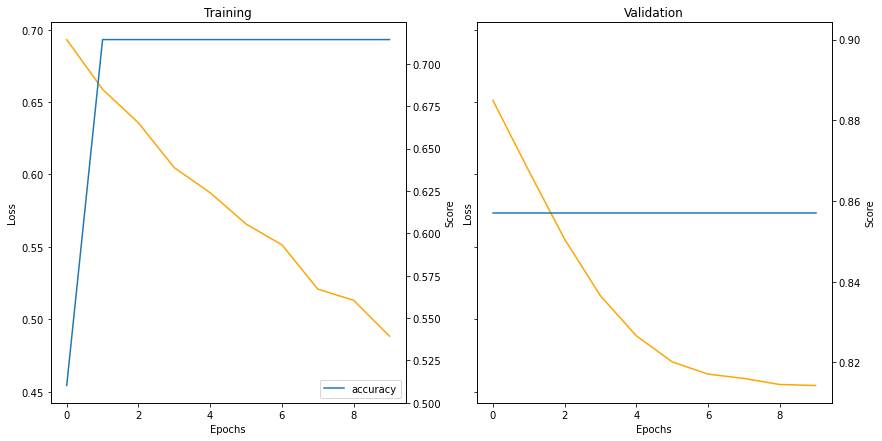

In [29]:
## plot loss and accuracy for neural network training
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=(14,7))

#plot training loss
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='orange',label='loss')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)  
ax11.set_ylabel("Score")
ax[0].set(title="Training")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax11.legend()


#plot validation loss
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='orange',label='loss')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score")
ax[1].set(title="Validation")
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [30]:
## test
y_train_prob = nn_model.predict(X_train)
y_train_pred = [np.argmax(pred) for pred in y_train_prob]

y_test_prob = nn_model.predict(X_test)
y_test_pred = [np.argmax(pred) for pred in y_test_prob]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


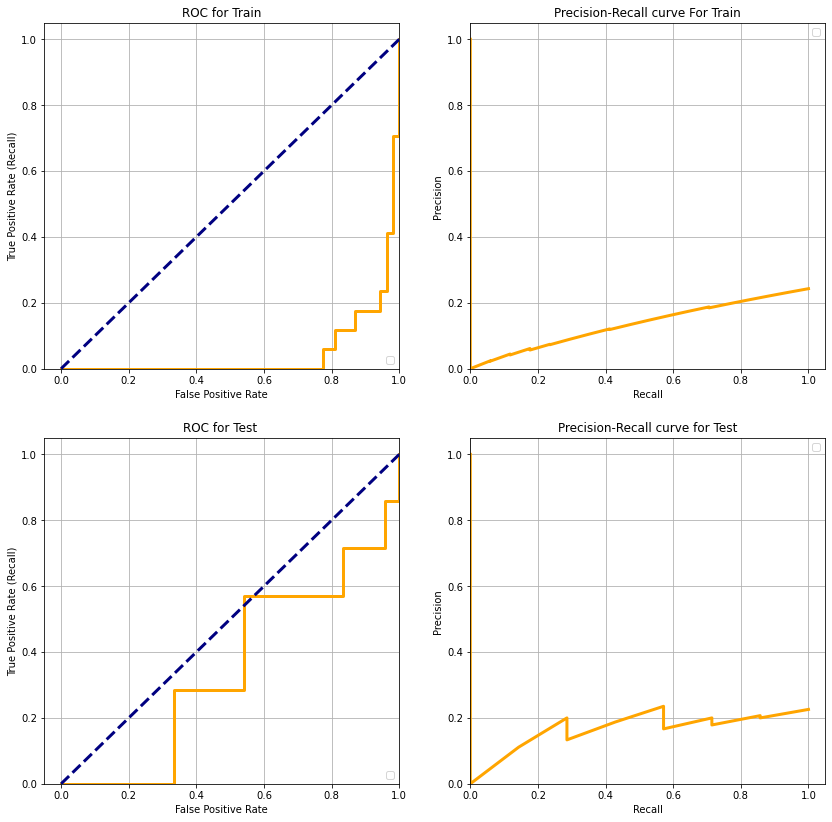

In [31]:
plot_roc_curve(y_te, y_test_prob,y_tr, y_train_prob)

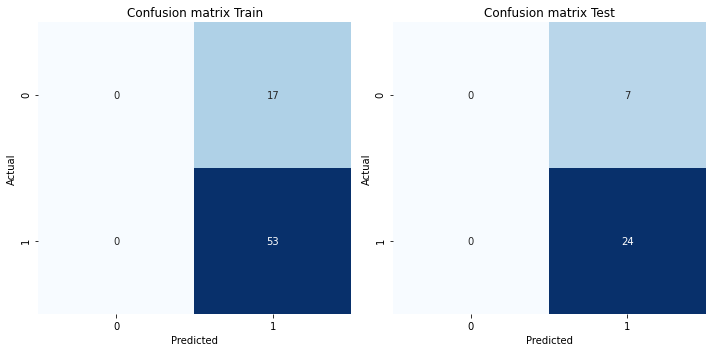


------------------------- Model evalution on Train data  ------------------------- 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        17
         1.0       0.76      1.00      0.86        53

    accuracy                           0.76        70
   macro avg       0.38      0.50      0.43        70
weighted avg       0.57      0.76      0.65        70


----------------------- Model evalution on validation data ----------------------- 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.77      1.00      0.87        24

    accuracy                           0.77        31
   macro avg       0.39      0.50      0.44        31
weighted avg       0.60      0.77      0.68        31



In [32]:
plot_confusion_matric(y_test, y_test_pred,y_train, y_train_pred)

### Ending Notes
<div id="id8"></div>

1. There are other methods to solve classification problems in text analytics, but they follow a similar kind of approach that is followed here.
2. Model performance improved, overfitting, underfitting problems can be resolved by collecting more data, regularization, and feature engineering.
3. Here we started from a simple classification model to a complex classification model, and the model would be picked based on the business requirements, metric scores, and deployment constraints.  